
# Classifier ansemble

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import mean_squared_error

# используем StratifiedKFold чтобы сохранить классовую несимметрию
from sklearn.model_selection import StratifiedKFold

import pickle

import warnings
warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(12, 6)})
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [2]:
# создаем набор регрессионных моделей
# лейблы
names_reg = ['GradientBoostingRegressor', 'LinearRegression', 'SGDRegressor',
            'KNeighborsRegressor']

# stack classifiers
regressors = [
    GradientBoostingRegressor(), 
    LinearRegression(n_jobs=-1),
    SGDRegressor(),
    KNeighborsRegressor(3)]

In [3]:
# функция обучения одной модели
# возвращает mean score при обучении на N фолдах
def cv_estimate(model=None, n_splits=3, train_X=None, train_y=None):
    cv = StratifiedKFold(n_splits=n_splits)
    val_scores = 0
    i = 1
    for train, test in cv.split(train_X, train_y):
        model.fit(train_X.iloc[train], train_y.iloc[train])
        #val_scores += model.score(train_X.iloc[test], train_y.iloc[test])
        val_scores += roc_auc_score(train_y.iloc[test], model.predict(train_X.iloc[test]))
        print(i, end=' ')
        i += 1
        
    val_scores /= n_splits
    return val_scores

In [4]:
# читаем данные для обучения (выборка train)
X = pd.read_csv('data/X.csv')
y = pd.read_csv('data/y.csv').iloc[:, 0]

In [5]:
X = X[['kpca_1', 'kpca_2']]

In [6]:
print(X.shape)
print(y.shape)

(347, 2)
(347,)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Learning regressors

In [8]:
models_score_reg = [[], []]
def learn_regressors():
    for name, reg in zip(names_reg, regressors):
        print(name, end=' ')
        score = cv_estimate(model=reg, n_splits=5, train_X=X_train, train_y=y_train)
        models_score_reg[0].append(name)
        models_score_reg[1].append(score)
        print()

In [9]:
%time learn_regressors()

GradientBoostingRegressor 1 2 3 4 5 
LinearRegression 1 2 3 4 5 
SGDRegressor 1 2 3 4 5 
KNeighborsRegressor 1 2 3 4 5 
CPU times: user 352 ms, sys: 16 ms, total: 368 ms
Wall time: 542 ms


In [10]:
models_score_reg = pd.DataFrame({'model':pd.Series(models_score_reg[0]),
                                   'roc_auc':pd.Series(models_score_reg[1])})\
                .sort_values(by='roc_auc', ascending=False)
models_score_reg

,model,roc_auc
1,LinearRegression,0.983829
2,SGDRegressor,0.966468
0,GradientBoostingRegressor,0.964905
3,KNeighborsRegressor,0.960319


In [11]:
best_reg = regressors[names_reg.index(models_score_reg.iloc[0, :].model)]

# Важность признаков (коэффициенты модели)

In [14]:
if 'feature_importances_' in dir(best_reg):
    clf_feature_reg = pd.DataFrame({'feature':X_train.columns, 
                                 names_reg[regressors.index(best_reg)]:best_reg.feature_importances_})\
                                .sort_values(by=names_reg[regressors.index(best_reg)], ascending=False)
elif 'coef_' in dir(best_reg):
    clf_feature_reg = pd.DataFrame({'feature':X_train.columns, 
                                 names_reg[regressors.index(best_reg)]:best_reg.coef_})\
                                .sort_values(by=names_reg[regressors.index(best_reg)], ascending=False)

clf_feature_reg = clf_feature_reg.rename(columns={names_reg[regressors.index(best_reg)]:'importance'})
clf_feature_reg.head(15)

,feature,importance
1,kpca_2,0.829290
0,kpca_1,-0.780264


# Оценка качества модели (roc_auc)

In [16]:
# predcition of best regressor
y_pred = best_reg.predict(X_test)

In [17]:
roc_auc_score(y_test, y_pred)

0.9807692307692308

In [18]:
mean_squared_error(y_test, y_pred)

0.07297674323841088

# Визуализация решения задачи

после понижения размерности с помощью алгоритма KernelPCA с ядром "rbf"

стало возможным линейное разделение данных

In [19]:
data_train = pd.read_csv('data/train_pca.csv')

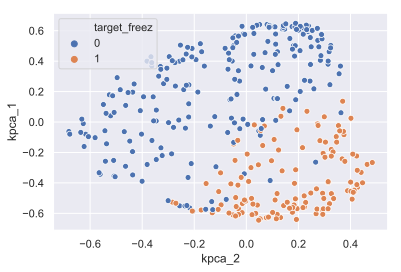

In [51]:
sns.scatterplot(x='kpca_2', y='kpca_1', data=data_train, hue='target_freez')

# Коэффициенты линейной регрессии

In [26]:
intercept, coefficients = best_reg.intercept_, best_reg.coef_
print(coefficients)
print(intercept)

[-0.78026419  0.82929048]
0.34778598522547743


# Сохраняем модель в файл

In [25]:
pickle.dump(best_reg, open('reports/model_reg.sav', 'wb'))